# Experimental data analysis

Reads raw QPD $(a,b,c,d,\text{trap})$ files, recovers trap $\sigma_x$ and $\sigma_y$, free diffusion constant $D$, and eventually corrects $y$ for $D_y \neq D_x$. Then generate $(x,y)$ file for MFPT computing with `exp-ft-automated.ipynb`.

For checking : can also use simulated trajectories with periodical trapping reset using Langevin's equation, from `langevin-generate.cpp` with `#define RESET_WITH_TRAPPING`, `#define ENABLE_PERIODICAL_RESET` and `#define SPLIT_FILES`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['savefig.bbox'] = 'tight'
import scipy.io
import scipy.optimize
import scipy.constants as cs
import pandas as pd
from utils import *

In [2]:
name = 'dati_MFPT/20-01-10/qpd_Ttrap50ms_Ttot200ms_'
N = (240,1000)
fps = 50000
std_calib = 0.03344148949490509
creneau_inv = 1
fit_diffus_t_end = 0.005 # choix du domaine de validité de la diffusion libre
y_correction_beg = 20
is_exp_data = True

In [2]:
name = 'dati_MFPT/20-01-10/qpd_Ttrap50ms_Ttot60ms_'
N = (1,230)
fps = 50000
std_calib = 0.03291502041883577
creneau_inv = 1
fit_diffus_t_end = 0.008
y_correction_beg = 2
is_exp_data = True

In [ ]:
name = 'test/langevin-trap-mass-traj-xyc'
N = (1,306)
fps = 100000.00
std_calib = sqrt(0.1)
creneau_inv = 1
fit_diffus_t_end = 0.06
D_calib = 5.0
y_correction_beg = 100
part_m = 0.0001
is_exp_data = False

### Chargement des données

In [3]:
def load_data (filename, creneau_inv, fps, is_exp_data):
    if is_exp_data:
        data = scipy.io.loadmat(filename)['data']
        # sorties de la QPD
        a = data[0][0::5]
        b = data[0][1::5]
        c = data[0][2::5]
        d = data[0][3::5]
        s = a+b+c+d
        # calcul de x et de y à partir des sorties QPD
        x = (a+b-c-d)/s
        y = (a-b-c+d)/s
        # laser de trapping on/off
        creneau = creneau_inv * data[0][4::5]
        thresh = creneau.mean()
        trapped = creneau > thresh # la particule est trapped
        free = np.logical_not(trapped) # la particule est libre
    else:
        data = np.fromfile(filename, np.dtype([('x',np.float64), ('y',np.float64), ('trapped',bool)]))
        x = data['x']
        y = data['y']
        trapped = data['trapped']
        free = np.logical_not(trapped)
    # temps
    t = np.arange(x.shape[0])/fps
    # indices correspondant au début/fin d'une période de trapping
    i_beg_trapping = np.where(np.logical_and(free[:-1],trapped[1:]))[0]
    i_end_trapping = np.where(np.logical_and(trapped[:-1],free[1:]))[0]
    
    return t,x,y,trapped,free,i_beg_trapping,i_end_trapping

### Exemple de trajectoire

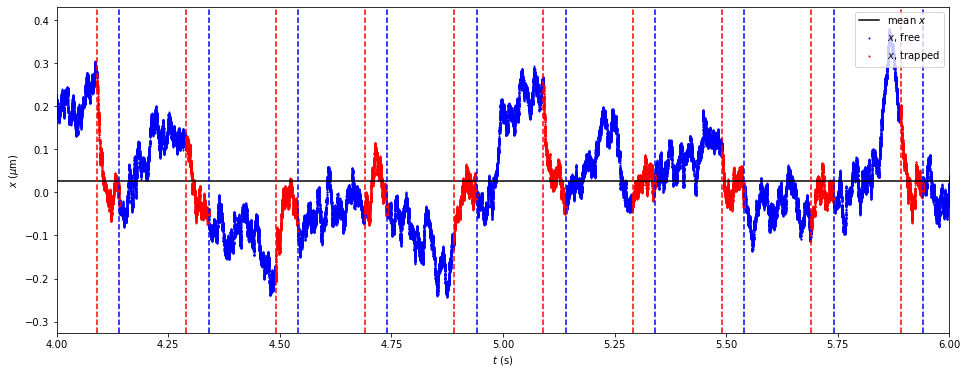

In [4]:
t,x,y,trapped,free,i_beg_trapping,i_end_trapping = load_data(name+str(N[1]//2), creneau_inv, fps, is_exp_data)
t_trap = t[trapped]
x_trap = x[trapped]
y_trap = y[trapped]
t_free = t[free]
x_free = x[free]
y_free = y[free]

plt.figure(figsize=(16,6))
plt.axhline(y=np.mean(x), color='black', label=r"mean $x$")
plt.scatter(t_free,x_free, color='blue', s=1, label=r"$x$, free", rasterized=True)
plt.scatter(t_trap,x_trap, color='red', s=1, label=r"$x$, trapped", rasterized=True)
for i in i_end_trapping:
    plt.axvline(x=t[i], linestyle='--', color='blue')
for i in i_beg_trapping:
    plt.axvline(x=t[i], linestyle='--', color='red')
plt.xlim((4,6))
plt.legend(loc='upper right')
plt.ylabel(r"$x$ ($\mu$m)")
plt.xlabel(r"$t$ (s)")
plt.savefig(name+"example_traj.pdf")

### Mesure de $\sigma_x$ et $\sigma_y$
en regardant la fin des périodes de trapping

In [5]:
x_end_trapping = []
y_end_trapping = []

length_trap = []
length_free = []

for w in range(N[0],N[1]+1):
    t,x,y,trapped,free,i_beg_trapping,i_end_trapping = load_data(name+str(w), creneau_inv, fps, is_exp_data)
    
    for i in i_end_trapping:
        x_end_trapping += list(x[i-10:i])
        y_end_trapping += list(y[i-10:i])
    
    k_beg = k_end = 0
    if i_beg_trapping[0] > i_end_trapping[0]:
        k_end = 1
    while k_beg < len(i_beg_trapping)-1 and k_end < len(i_end_trapping):
        assert i_beg_trapping[k_beg] < i_end_trapping[k_end]
        length_trap.append( i_end_trapping[k_end] - i_beg_trapping[k_beg] )
        length_free.append( i_beg_trapping[k_beg+1] - i_end_trapping[k_end] )
        k_beg += 1
        k_end += 1

    print(w, end=' ')

length_trap = np.min(length_trap)
length_free = np.min(length_free)
length_trap,length_free

240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 

(2500, 7499)

Aggrégat de points à la fin des périodes de trapping, de tous les fichiers :

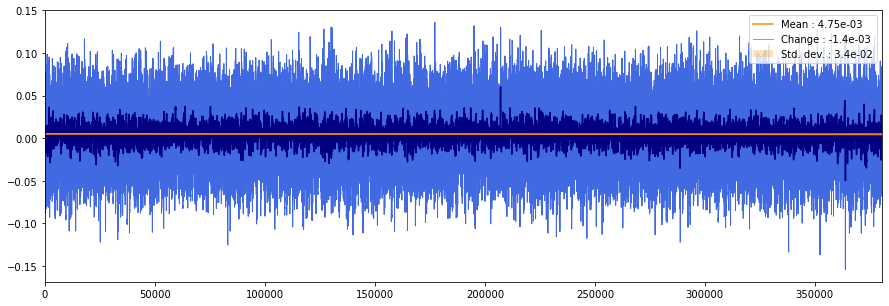

In [6]:
x0,sigma_x,slope = plot_means_synth( np.arange(len(x_end_trapping)), np.array(x_end_trapping), cmak=60 )

Distribution de $x$ en fin de trapping, ajustement sur une gaussienne :

centre en x : 4.75e-03; variance de x_0 : 3.39e-02


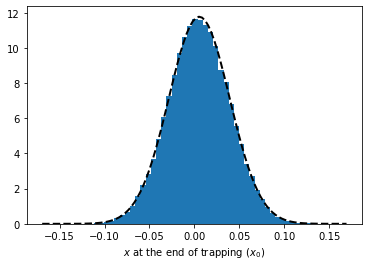

In [7]:
x_end_trapping_detrend = np.array(x_end_trapping) - slope*np.arange(len(x_end_trapping))
_,sigma_x = check_gaussian(x_end_trapping_detrend, bins=50, xlabel=r"$x$ at the end of trapping ($x_0$)")
print("centre en x : {:.2e}; variance de x_0 : {:.2e}".format(x0,sigma_x))

Même chose pour $y$.

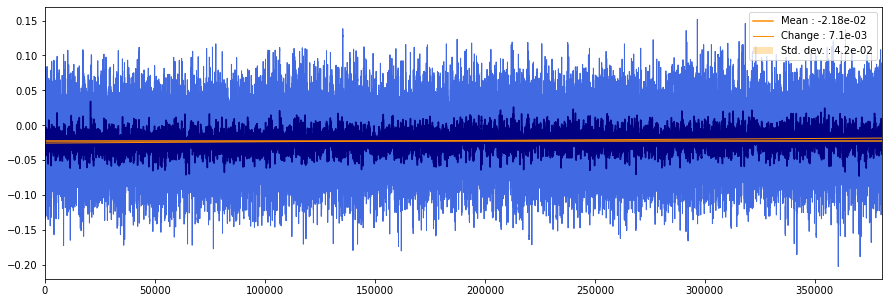

In [8]:
y0,sigma_y,slope = plot_means_synth( np.arange(len(y_end_trapping)), np.array(y_end_trapping), cmak=60 )

centre en y : -2.18e-02; variance de y_0 : 4.18e-02


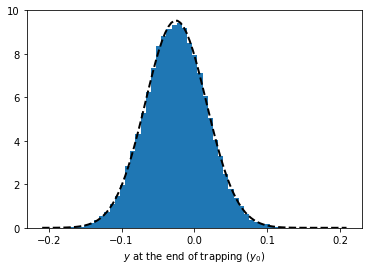

In [9]:
y_end_trapping_detrend = np.array(y_end_trapping) - slope*np.arange(len(y_end_trapping))
_,sigma_y = check_gaussian(y_end_trapping_detrend, bins=50, xlabel=r"$y$ at the end of trapping ($y_0$)")
print("centre en y : {:.2e}; variance de y_0 : {:.2e}".format(y0,sigma_y))

### Courbes moyennes de $x^2$ et $y^2$ sur les périodes de diffusion libre
pour corriger une éventuelle différence d'échelle entre $x$ et $y$

In [10]:
diffus_sn = 30
diffus_t = np.arange(length_free//diffus_sn) / fps * diffus_sn
diffus_x2_acc = [ [] for _ in range(len(diffus_t)) ]
diffus_y2_acc = [ [] for _ in range(len(diffus_t)) ]

for w in range(N[0],N[1]):
    t,x,y,trapped,free,i_beg_trapping,i_end_trapping = load_data(name+str(w), creneau_inv, fps, is_exp_data)
    
    k_beg = k_end = 0
    if i_beg_trapping[0] > i_end_trapping[0]:
        k_end = 1
    while k_beg < len(i_beg_trapping)-1 and k_end < len(i_end_trapping):
        
        traj_diffus_x = x[ i_end_trapping[k_end]:i_beg_trapping[k_beg+1] ] - x0
        traj_diffus_y = y[ i_end_trapping[k_end]:i_beg_trapping[k_beg+1] ] - y0
        for k in range(length_free//diffus_sn):
            i = k*diffus_sn
            diffus_x2_acc[k].append(traj_diffus_x[i]**2)
            diffus_y2_acc[k].append(traj_diffus_y[i]**2)
        
        k_beg += 1
        k_end += 1
        
    print(w, end=' ')

240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 

In [11]:
def plot_R2 (t, R2_acc, varname="r", fit_diffus_t_end=None, fit_diffus_sigma0=None, fit_diffus_d=None):
    R2 = np.zeros(len(t))
    R2std = np.zeros(len(t))
    for k in range(len(t)):
        R2[k] = np.mean(R2_acc[k])
        R2std[k] = np.std(R2_acc[k])
    n = len(R2_acc[0])
    plt.figure(figsize=(10,7))
    ax1 = plt.gca()
    ax1.fill_between(t, R2-R2std, R2+R2std, facecolor='orange', alpha=0.3, label=r"$\pm \operatorname{std}("+varname+"^2)$")
    ax1.fill_between(t, R2-R2std/np.sqrt(n), R2+R2std/np.sqrt(n), facecolor='orange', alpha=0.5)
    ax1.plot(t, R2, label=r"$\langle "+varname+r"^2 \rangle_\operatorname{ens}(t)$", lw=2)
    ax1.set_ylim((0,1.1*np.max(R2)))
    ax1.set_xlabel(r"$t$")
    if fit_diffus_t_end is not None:
        assert fit_diffus_t_end < t[-1]
        k1 = np.searchsorted(t, fit_diffus_t_end)+1
        _coeff, _cov = scipy.optimize.curve_fit( (lambda t,D: D*t), t[:k1]-t[0], R2[:k1]-fit_diffus_sigma0**2, sigma=np.ones(k1) )
        D = _coeff[0]
        D_err = 15*sqrt(np.diag(_cov)[0]) + D*R2std[k1]/R2[k1]/np.sqrt(n)
        ax1.plot(t[:k1], fit_diffus_sigma0**2+D*(t[:k1]-t[0]), '--', color='black', label=r"${}D={:.3f}\pm{:.3f}$".format(2*fit_diffus_d,D,D_err))
        ax1.plot(t[:k1], fit_diffus_sigma0**2+(D+D_err)*(t[:k1]-t[0]), '--', color='grey', lw=1)
        ax1.plot(t[:k1], fit_diffus_sigma0**2+(D-D_err)*(t[:k1]-t[0]), '--', color='grey', lw=1)
        return ax1,R2,R2std,D/(2*fit_diffus_d),D_err/(2*fit_diffus_d)
    return ax1,R2,R2std

fit on 0->0.01 : D_x = 0.1388 ± 2.9%


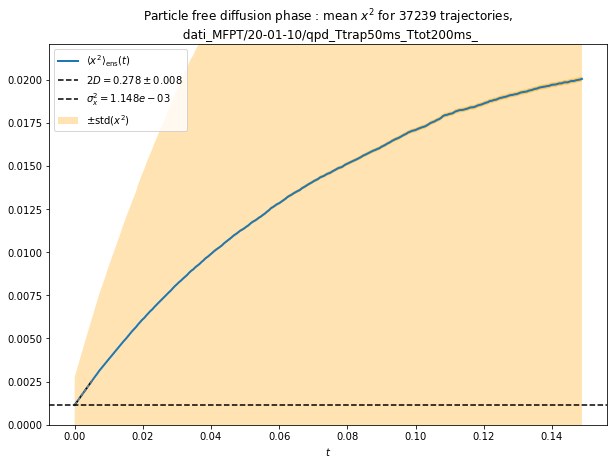

In [12]:
ax,diffus_x2,diffus_x2std,Dx,Dx_err = plot_R2(diffus_t, diffus_x2_acc, "x", fit_diffus_t_end, sigma_x, 1)
print("fit on 0->{:.2f} : D_x = {:.4f} ± {:.1f}%".format(fit_diffus_t_end,Dx,Dx_err/Dx*100))
ax.axhline(y=sigma_x**2, label=r"$\sigma_x^2={:.3e}$".format(sigma_x**2), color='black', linestyle='--')
ax.legend()
plt.title("Particle free diffusion phase : mean $x^2$ for {} trajectories,\n {}".format(len(diffus_x2_acc[0]), name))
plt.savefig(name+"diffus_x2.pdf")

fit on 0->0.01 : D_y_raw = 0.1397 ± 3.3%


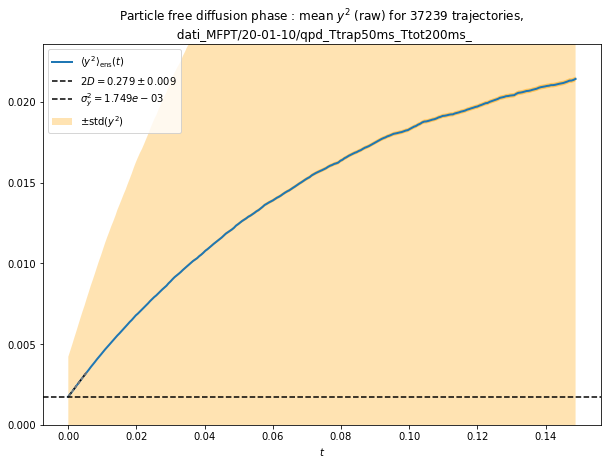

In [13]:
ax,diffus_y2,diffus_y2std,Dy,Dy_err = plot_R2(diffus_t, diffus_y2_acc, "y", fit_diffus_t_end, sigma_y, 1)
print("fit on 0->{:.2f} : D_y_raw = {:.4f} ± {:.1f}%".format(fit_diffus_t_end,Dy,Dy_err/Dy*100))
ax.axhline(y=sigma_y**2, label=r"$\sigma_y^2={:.3e}$".format(sigma_y**2), color='black', linestyle='--')
ax.legend()
plt.title("Particle free diffusion phase : mean $y^2$ (raw) for {} trajectories,\n {}".format(len(diffus_y2_acc[0]), name))
plt.savefig(name+"diffus_y2_raw.pdf")

Correction de l'échelle de $y$ pour que les courbes de diffusion en $x$ et en $y$ coïncident :

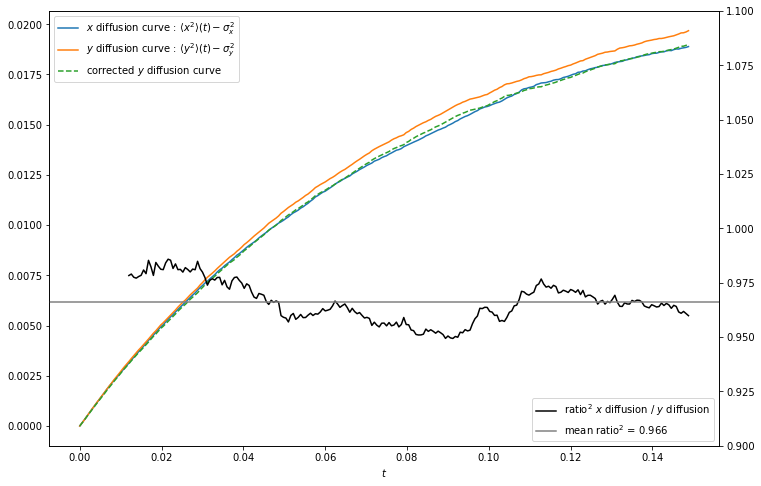

In [14]:
plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax1.plot(diffus_t, diffus_x2-sigma_x**2, label=r"$x$ diffusion curve : $\langle x^2 \rangle(t)-\sigma_x^2$")
ax1.plot(diffus_t, diffus_y2-sigma_y**2, label=r"$y$ diffusion curve : $\langle y^2 \rangle(t)-\sigma_y^2$")

ax2 = ax1.twinx()
ratio_x2_y2 = (diffus_x2-sigma_x**2) / (diffus_y2-sigma_y**2)
ax2.plot( diffus_t[y_correction_beg:], ratio_x2_y2[y_correction_beg:], label=r"ratio$^2$ $x$ diffusion / $y$ diffusion", color='black' )
ratio_x2_y2 = np.mean(ratio_x2_y2[y_correction_beg:])
ax2.axhline(y=ratio_x2_y2, label="mean ratio$^2$ = {:.3f}".format(ratio_x2_y2), color='grey')
ax2.set_ylim((0.9,1.1))

ax1.plot(diffus_t, (diffus_y2-sigma_y**2)*ratio_x2_y2, label=r"corrected $y$ diffusion curve", linestyle='--')

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
ax1.set_xlabel(r"$t$")

plt.savefig(name+"correction_y.pdf")

### Courbes moyennes de $r^2$ après correction sur $y$

In [15]:
ratio_x_y = np.sqrt(ratio_x2_y2)
print(ratio_x_y)
sigma_y *= ratio_x_y
print(sigma_x, sigma_y)
sigma = np.sqrt( sigma_x**2 + sigma_y**2 )
print(sigma)

0.9828440944231122
0.033886043718505 0.04110407205044744
0.053271086886047356


In [16]:
trapped_sn = 20
trapped_t = np.arange(length_trap//trapped_sn) / fps * trapped_sn
trapped_R2_acc = [ [] for _ in range(len(trapped_t)) ]
diffus_sn = 30
diffus_t = np.arange(length_free//diffus_sn) / fps * diffus_sn
diffus_R2_acc = [ [] for _ in range(len(diffus_t)) ]
diffus_mass_center_x = np.zeros(len(diffus_t))
diffus_mass_center_y = np.zeros(len(diffus_t))

i_end_traj = int(fit_diffus_t_end * fps)
file = open(name+"traj_data.bin", "wb")

for w in range(N[0],N[1]):
    t,x,y,trapped,free,i_beg_trapping,i_end_trapping = load_data(name+str(w), creneau_inv, fps, is_exp_data)
    
    k_beg = k_end = 0
    if i_beg_trapping[0] > i_end_trapping[0]:
        k_end = 1
    while k_beg < len(i_beg_trapping)-1 and k_end < len(i_end_trapping):
        
        traj_trapped_x =   x[ i_beg_trapping[k_beg]:i_end_trapping[k_end] ] - x0
        traj_trapped_y = ( y[ i_beg_trapping[k_beg]:i_end_trapping[k_end] ] - y0 ) * ratio_x_y
        for k in range(length_trap//trapped_sn):
            i = k*trapped_sn
            r2 = traj_trapped_x[i]**2 + traj_trapped_y[i]**2
            trapped_R2_acc[k].append(r2)
        
        traj_diffus_x =   x[ i_end_trapping[k_end]:i_beg_trapping[k_beg+1] ] - x0
        traj_diffus_y = ( y[ i_end_trapping[k_end]:i_beg_trapping[k_beg+1] ] - y0 ) * ratio_x_y
        for k in range(length_free//diffus_sn):
            i = k*diffus_sn
            r2 = traj_diffus_x[i]**2 + traj_diffus_y[i]**2
            diffus_R2_acc[k].append(r2)
            diffus_mass_center_x[k] += traj_diffus_x[i]
            diffus_mass_center_y[k] += traj_diffus_y[i]
            
        data = np.empty((2*i_end_traj+2,), dtype=np.float64)
        data[0] = data[1] = np.nan
        data[2::2] = traj_diffus_x[:i_end_traj]
        data[3::2] = traj_diffus_y[:i_end_traj]
        data.tofile(file)
        
        k_beg += 1
        k_end += 1
        
    print(w, end=' ')

file.close()

240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 

$r^2$ moyen pendant la phase de trapping de la particule, juste pour vérifier que le trapping fonctionne bien, qu'il dure suffisemment longtemps, et que la détermination de $\sigma$ est cohérente :

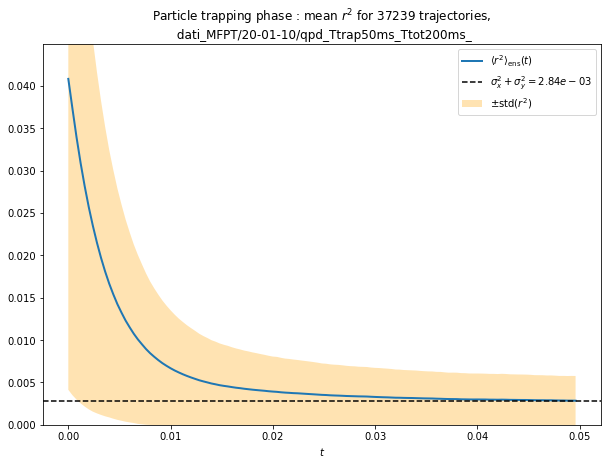

In [17]:
ax,trapped_R2,trapped_R2std = plot_R2(trapped_t, trapped_R2_acc)
ax.axhline(y=sigma**2, label=r"$\sigma_x^2+\sigma_y^2={:.2e}$".format(sigma**2), color='black', linestyle='--')
ax.legend()
plt.title("Particle trapping phase : mean $r^2$ for {} trajectories,\n {}".format(len(trapped_R2_acc[0]), name))
plt.savefig(name+"trapping_r2.pdf")

$r^2$ moyen pendant la phase de diffusion libre, et détermination finale du coefficient de diffusion $D$ sur le domaine de validité choisi :

0.1368909374260958
0.13689093742539468


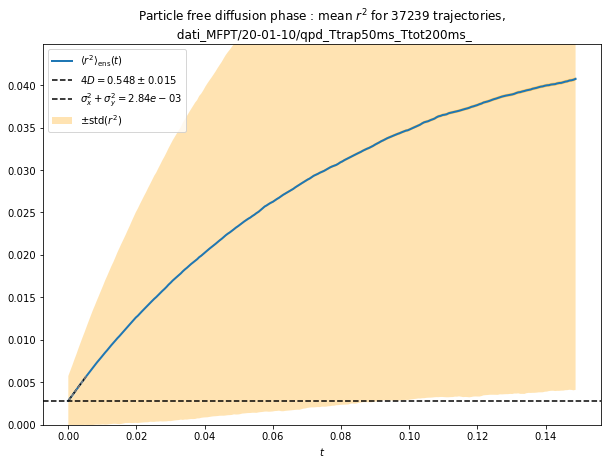

In [18]:
ax,diffus_R2,diffus_R2std,D,D_err = plot_R2(diffus_t, diffus_R2_acc, "r", fit_diffus_t_end, sigma, 2)
ax.axhline(y=sigma**2, label=r"$\sigma_x^2+\sigma_y^2={:.2e}$".format(sigma**2), color='black', linestyle='--')
print(D)
print((Dx + Dy*ratio_x2_y2)/2)
ax.legend()
plt.title("Particle free diffusion phase : mean $r^2$ for {} trajectories,\n {}".format(len(diffus_R2_acc[0]), name))
plt.savefig(name+"diffus_r2_corr.pdf")

In [19]:
pd.DataFrame(list({
    'N_traj': len(diffus_R2_acc),
    'ratio_x_y': ratio_x_y,
    'sigma_x': sigma_x,
    'sigma_y': sigma_y,
    'D': D,
    'D_err': D_err,
    'fps': fps,
    'reset_period': fit_diffus_t_end,
}.items())).set_index(0).to_csv(name+"diffus.csv", header=False, sep=',')

Déviation systématique de la particule dans la phase de diffusion libre :

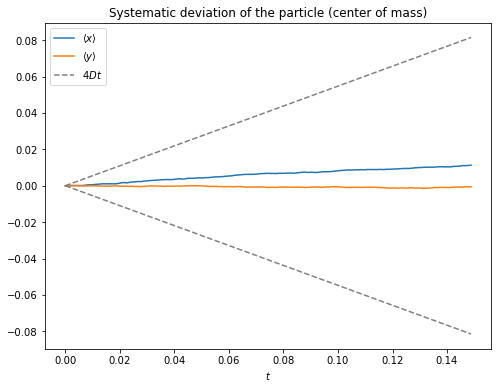

In [20]:
plt.figure(figsize=(8,6))
plt.plot(diffus_t, diffus_mass_center_x/len(diffus_R2_acc[0]), label=r"$\langle x \rangle$")
plt.plot(diffus_t, diffus_mass_center_y/len(diffus_R2_acc[0]), label=r"$\langle y \rangle$" )
plt.plot(diffus_t, +4*D*diffus_t, '--', color='grey', label=r"$4Dt$")
plt.plot(diffus_t, -4*D*diffus_t, '--', color='grey')
plt.legend()
plt.title("Systematic deviation of the particle (center of mass)")
plt.xlabel("$t$")
plt.savefig(name+"sysdev.pdf")